In [ ]:
import sys
sys.path.append('../')

import torch
import torch.nn as nn
from einops import rearrange
import matplotlib.pyplot as plt
from modules import Model

CausalRevIN - L1: 2.624659538269043


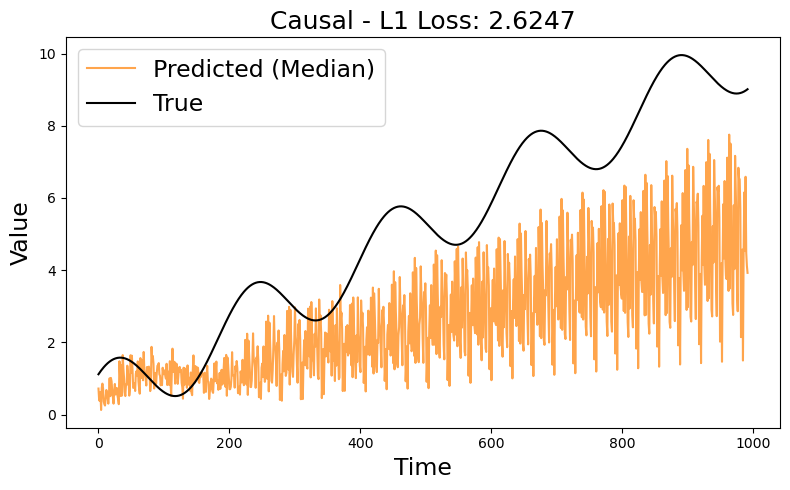

RevIN - L1: 2.8115553855895996


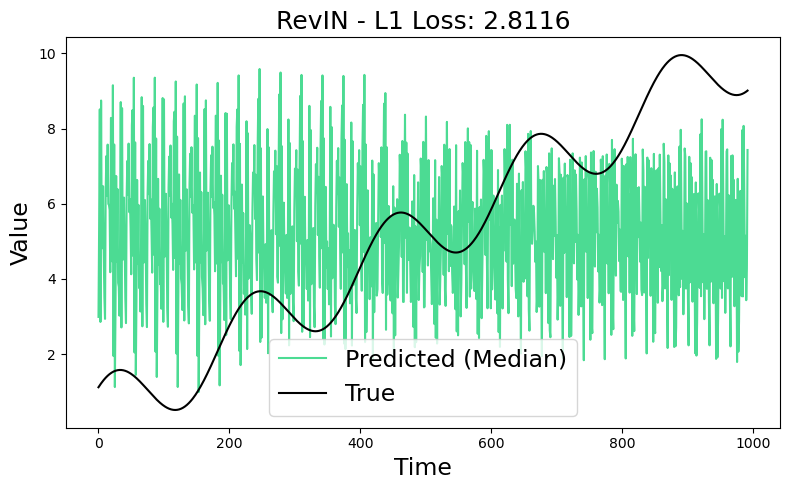

PrefixRevIN - L1: 4.051947593688965


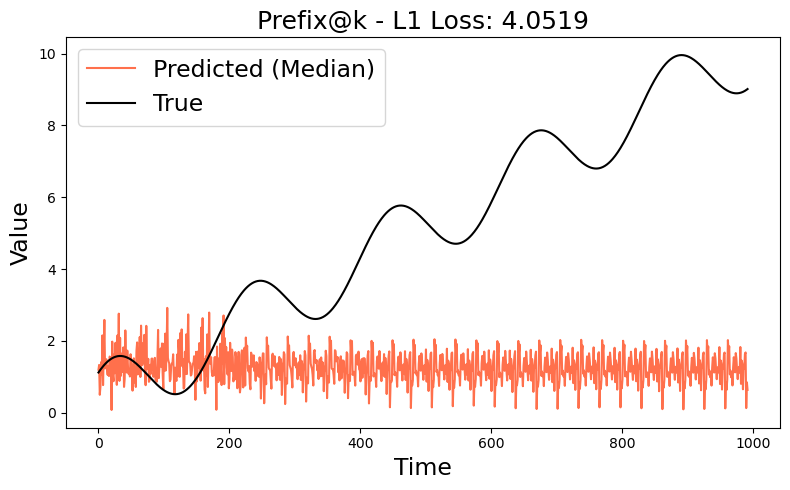

In [ ]:
conf_name={
    "CausalRevIN": "Causal",
    "RevIN": "RevIN",
    "PrefixRevIN": "Prefix@k"
}

dic_model_colors = {
    "CausalRevIN":          "#FF7F00",  # vivid orange
    "RevIN":                 "#00CC66",  # vivid green
    "PrefixRevIN":              "#FF3300",  # bright red-orange
}

for rev_config in ["CausalRevIN", "RevIN", "PrefixRevIN"]:

    model = Model(
        patch_len=32, d_model=2048, n_heads=64, n_layers_encoder=6, revin_config_name=rev_config, use_asinh=False, 
        quantiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], dropout=0.)

    x = torch.linspace(0, 10, 1024).unsqueeze(0).repeat(16, 1)
    y = torch.sin(3*x) + x
    predictions = model(y)  # Forward pass in training
    predictions = predictions[:, :-1, :,]

    x_patch = rearrange(y, 'b (n p) -> b n p', p=32)[:, 1:, :]
    loss = nn.L1Loss()
    loss_value = loss(predictions, x_patch)
    print(f"{rev_config} - L1: {loss_value.item()}")

    plt.figure(figsize=(8, 5))
    plt.plot(predictions[0].flatten().detach().cpu(), label="Predicted (Median)", color=dic_model_colors[rev_config], alpha=0.7)
    plt.plot(x_patch[0, :, :].flatten().cpu(), label="True", color="black")
    plt.title(f"{conf_name[rev_config]} - L1 Loss: {loss_value.item():.4f}", fontsize=18)
    plt.xlabel("Time", fontsize=17)
    plt.ylabel("Value", fontsize=17)
    plt.legend(fontsize=17)
    plt.tight_layout()
    plt.savefig(f"figures/startloss/starting_loss_{rev_config}.pdf", dpi=300, bbox_inches='tight')
    plt.show()